<a href="https://colab.research.google.com/github/leekj3133/dss_JU/blob/main/Dacon/Lv3.%20%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D%EA%B3%BC%20LGBM%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%99%80%EC%9D%B8%20%ED%92%88%EC%A7%88%20%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0/Lv3_%EB%AA%A8%EB%8D%B8%EB%A7%81_3_4_%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D_%EC%A0%95%EC%9D%98%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [↩️ 리스트로 돌아가기](https://dacon.io/competitions/open/235698/overview/description)

# 셀을 실행할 때 팝업이 뜨면 `무시하고 계속하기` 를 눌러주세요


## 데이터 다운로드
---
아래 셀을 실행시켜 데이터를 colab 에 불러옵니다.
셀 실행은 Ctrl + Enter 를 이용해 실행시킬 수 있습니다.

In [1]:
# 데이터 다운로드 링크로 데이터를 코랩에 불러옵니다.

!wget 'https://bit.ly/3i4n1QB'

import zipfile
with zipfile.ZipFile('3i4n1QB', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-09-13 08:18:38--  https://bit.ly/3i4n1QB
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw [following]
--2021-09-13 08:18:38--  https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3ehvkpk5drqpjlqos6a6kjgb299ofgmv/1631521050000/17946651057176172524/*/1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw?e=download [following]
--2021-09-13 08:18:39--  https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcu

In [2]:
# 라이브러리 불러오기

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_csv('data/train.csv')

# Scailing
scaler = MinMaxScaler()
scaler.fit(train[['fixed acidity']])
train['Scaled fixed acidity'] = scaler.transform(train[['fixed acidity']])

# Encoding
encoder = OneHotEncoder()
encoder.fit(train[['type']])
onehot = encoder.transform(train[['type']])
onehot = onehot.toarray()
onehot = pd.DataFrame(onehot)
onehot.columns = encoder.get_feature_names()
train = pd.concat([train, onehot], axis = 1)
train = train.drop(columns = ['type'])
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Scaled fixed acidity,x0_red,x0_white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0.148760,0.0,1.0
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,0.413223,1.0,0.0
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0.338843,0.0,1.0
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0.264463,0.0,1.0
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0.330579,0.0,1.0


## 교차 검증

### Hold-Out
- 단순하게 Train 데이터를 (train, valid)라는 이름의 2개의 데이터로 나누는 작업
- 보통 train : valid = 8:2 혹은 7:3의 비율로 데이터 나눔
- 나누는 이유 : 측 성능을 가늠해보기 위해서
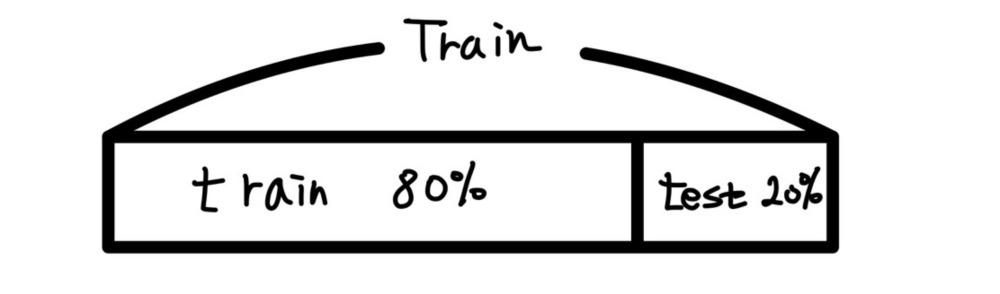

- Train : train.csv를 통해서 불러온 데이터

- train : Train을 8:2로 쪼갠 큰 부분

- test(=valid) : Train의 거대한 데이터를 8:2로 쪼갠 작은 부분

- 모델이 80%의 데이터를 통해서 학습, 20%의 데이터 예측 



-문제점 :  데이터의 낭비
  - 단순하게 trian과 test로 분할하게 된다면, 20%의 데이터는 모델이 학습할 기회도 없이, 예측만하고 버려지게 됨



## K-Fold(교차검증)
- 모든 데이터를 최소한 한 번씩 다 학습하게 하자
- valid 데이터를 겹치지 않게 나누어 N개의 데이터셋을 만듦
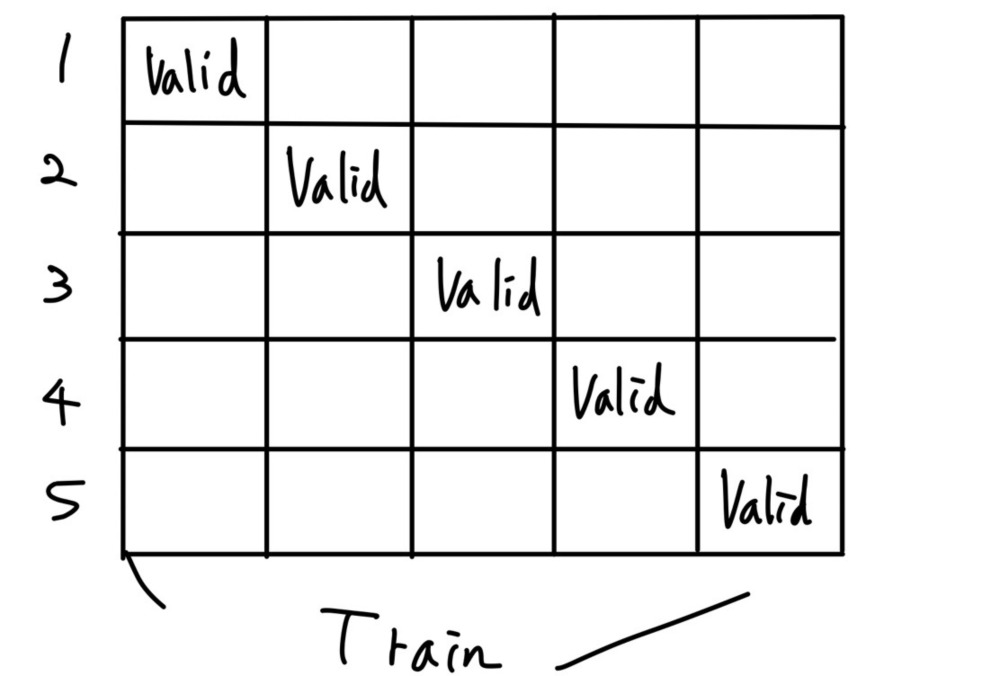
데이터셋을 5개로 만든다고 하면, (== valid size가 20%) 겹치지 않게 위와 같은 모양으로 만들 수 있음.

그리고 반복문을 통해서 1번부터 5번 데이터들에 들어갔다가 나오면서, 데이터를 모두 최소한 한번씩 학습 가능하게 됨.

## 👋 실습
---

In [4]:
# sklearn에 model_selection 부분 속 KFold를 불러와보세요
from sklearn.model_selection import KFold

In [5]:
# KFold에 n_splits = 5, shuffle = True, random_state = 0이라는 인자를 추가해 "kf"라는 변수에 저장해보세요
kf = KFold( n_splits = 5, shuffle = True, random_state = 0)

In [8]:
# 반복문을 통해서 1번부터 5번까지의 데이터에 접근해보세요
for train_idx, valid_idx in kf.split(train):
  train_data = train.iloc[train_idx]
  valid_data = train.iloc[valid_idx]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


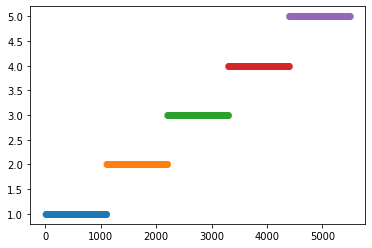

In [9]:
import matplotlib.pyplot as plt


kf = KFold(n_splits = 5, shuffle = False, random_state = 0)
train_idx_store = []
valid_idx_store = []

i = 1
for train_idx, valid_idx in kf.split(train) :
  plt.scatter(valid_idx, [i for x in range(len(valid_idx))], alpha = 0.1)
  i += 1
plt.show()


## 아래의 이미지는 shuffle = False로 했을 때, 데이터가 겹치지 않게 순서대로 쪼개지는 것을 볼 수 있습니다.

## 정답
---

In [ ]:
# sklearn에 model_selection 부분 속 KFold를 불러와보세요
from sklearn.model_selection import KFold

In [ ]:
# KFold에 n_splits = 5, shuffle = True, random_state = 0이라는 인자를 추가해 "kf"라는 변수에 저장해보세요
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
# 반복문을 통해서 1번부터 5번까지의 데이터에 접근해보세요

for train_idx, valid_idx in kf.split(train) :
  train_data = train.iloc[train_idx]
  valid_data = train.iloc[valid_idx]

In [ ]:
# 이 코드는 순서대로 이해하려 해보세요 :)

import matplotlib.pyplot as plt


kf = KFold(n_splits = 5, shuffle = False, random_state = 0)
train_idx_store = []
valid_idx_store = []

i = 1
for train_idx, valid_idx in kf.split(train) :
  plt.scatter(valid_idx, [i for x in range(len(valid_idx))], alpha = 0.1)
  i += 1
plt.show()


## 아래의 이미지는 shuffle = False로 했을 때, 데이터가 겹치지 않게 순서대로 쪼개지는 것을 볼 수 있습니다.

# [↩️ 리스트로 돌아가기](https://dacon.io/competitions/open/235698/overview/description)